## *The Elder Scrolls Online* Crafting Material Prices

In early 2017, *The Elder Scrolls Online* released a free update adding player housing to the game. Materials to craft the furnishings used in homes have since become a large part of the game's economy. There are seven crafting professions, and each has at least one item exclusively used to make furnishings: regulus for blacksmithing, bast and clean pelts for clothing, heartwood for woodworking, ochre for jewelry crafting, alchemical resin for alchemy, mundane runes for enchanting, and decorative wax for provisioning. With the exception of decorative wax and clean pelts (which are found on bugs and animals, respectively), each item has a chance to drop when a player harvests the resource node associated with its profession. This project analyzes the price of furniture crafting materials and why some items have dramatically increased in price over the years while others have remained roughly the same.
*********

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns

In [2]:
def draw_event(date, dur, subpl, type):  # create rectangles to represent event periods
    xy = date, subpl.get_ylim()[0]
    w, h = timedelta(days=dur), subpl.get_ylim()[1] - subpl.get_ylim()[0]
    subpl.add_patch(Rectangle(xy, w, h, **type))

In [3]:
def change_plot(mat, year, lefty1, lefty2, righty1, righty2, nticks):  # twin y change plots
    fig.suptitle("change in price vs quantity: " + mat)
    ax1.plot(price_diff[mat], c=c["c1"], lw=1.2, alpha=0.75)
    ax1.set_ylabel("price change", c=c["c1"])
    ax1.set_xlabel(year, **titlefnt2)
    ax1.set_xlim(dates["xl" + year], dates["xr" + year])
    ax1.set_ylim(lefty1, lefty2)

    ax2 = ax1.twinx()
    ax2.plot(quant_diff[mat], c=c["c2"], lw=1.5, alpha=0.75)
    ax2.set_ylabel("quantity change", c=c["c2"])
    ax2.set_ylim(righty1, righty2)

    # format ticks & labels
    ax1.tick_params(axis="x", **xticks)
    ax1.tick_params(axis="y", **grid)
    ax2.tick_params(axis="y", **grid)
    ax2.grid(None)

    ax1.yaxis.set_major_locator(mticker.LinearLocator(nticks))
    ax2.yaxis.set_major_locator(mticker.LinearLocator(nticks))

    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

    ax2.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: "{:,.1f}".format(x / 1000) + "K")
    )

In [4]:
# import csv from google sheets and convert 'Date' column to datetime + set as index
sheet_id = "15ooJmi30BiE3ZhbNsGNG0Ct2gL-tRcoFMbLKLjQGqbU"
sheet_name = "prices"
url = (
    f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
)

df = pd.read_csv(url, parse_dates=["Date"], index_col=["Date"])

In [5]:
# filter to price & quantity of main items
price = df.filter(
    items=[
        "Date",
        "Regulus Price",
        "Bast Price",
        "Wood Price",
        "Resin Price",
        "Rune Price",
        "Wax Price",
    ]
)
quantity = df.filter(
    items=[
        "Date",
        "Regulus Quantity Listed",
        "Bast Quantity Listed",
        "Wood Quantity Listed",
        "Resin Quantity Listed",
        "Rune Quantity Listed",
        "Wax Quantity Listed",
    ]
)

# simplify column names
labels = ["regulus", "bast", "wood", "resin", "rune", "wax"]
price.columns = labels
quantity.columns = labels

# separate tracked periods of time
price_2020 = price.loc["2020":"2021"]
price_2022 = price.loc["2022":]

# remove missing values
price = price.dropna()
quantity = quantity.dropna()

I separated price and quantity, and focused on the six main materials (excluding clean pelts, as it's a secondary material for clothing, and ochre, since jewelry crafting is the only profession locked behind DLC). Columns were renamed for readability. I also separated prices by year, since there's a gap from February 2021 until March 2022, and I wanted to analyze the tracked time periods separately.

In [6]:
# find min and max prices with dates for 2020 & 2022
price_idxmin20 = price_2020.idxmin()
price_min20 = price_2020.min()
price_idxmin22 = price_2022.idxmin()
price_min22 = price_2022.min()
price_idxmax20 = price_2020.idxmax()
price_max20 = price_2020.max()
price_idxmax22 = price_2022.idxmax()
price_max22 = price_2022.max()

# combine into dataframe
price_info = pd.concat(
    [
        price_idxmin20,
        price_min20,
        price_idxmax20,
        price_max20,
        price_idxmin22,
        price_min22,
        price_idxmax22,
        price_max22,
    ],
    axis=1,
)

cols = [
    "Date of Minimum (2020)",
    "Mininimum (2020)",
    "Date of Maximum (2020)",
    "Maximum (2020)",
    "Date of Minimum 2022",
    "Minimum (2022)",
    "Date of Maximum (2020)",
    "Maximum (2020)",
]
price_info.columns = cols  # label columns

display(price_info)

,Date of Minimum (2020),Mininimum (2020),Date of Maximum (2020),Maximum (2020),Date of Minimum 2022,Minimum (2022),Date of Maximum (2020),Maximum (2020)
regulus,2020-10-07,23.0,2020-12-29,85.0,2022-04-23,57.0,2022-07-27,95.0
bast,2020-09-26,22.0,2020-12-26,107.0,2022-04-16,38.0,2022-08-31,55.0
wood,2020-09-21,351.0,2020-12-22,1115.0,2022-04-16,1189.0,2022-09-04,1707.0
resin,2020-09-21,9.0,2020-10-20,12.0,2022-03-26,17.0,2022-08-27,23.0
rune,2020-09-21,517.0,2021-01-28,706.0,2022-04-16,1182.0,2022-09-04,1695.0
wax,2020-09-21,344.0,2020-10-20,512.0,2022-04-20,710.0,2022-09-04,994.0


#### Minimum and Maximum Prices (September 2020 - February 2021 vs. March - July 2022)

The date of minimum prices (2020) column shows that all items hit their lowest prices near (or at) the first recorded date. Minimum prices for 2020 are all significantly lower than the minimum prices for 2022, and even the maximum prices for 2020 are lower than the 2022 minimums for all but regulus and bast. Regulus,  bast, and heartwood all hit their maximum 2020 prices in the last nine days of December.

For 2022, all but one item (alchemical resin) has its lowest price between April 16th-23rd. Mundane runes, decorative wax, and alchemical resin all hit their highest prices in the first 8 days of June, while regulus and heartwood are at their highest on July 20th. Bast is the only item that hit its maximum 2022 price at the earliest recorded date that year.
*****************

In [7]:
# plot formatting
colors = {
    "regulus": "#4E6F6F",
    "bast": "#4E6F6F",
    "wood": "#ff6d00",
    "resin": "#4E6F6F",
    "rune": "#4E6F6F",
    "wax": "#4E6F6F",
}

c = {"t": "#556868", "c1": "#ff6d00", "c2": "#58BABB"}

event = {"ec": None, "color": "w", "alpha": 0.5}  # events without increased drop rate
expl = {
    "ec": None,
    "color": "#DBFFE6",
    "alpha": 0.5,
}  # events with 2x crafting mat drop rate
update = {"lw": 1.8, "linestyle": "dotted", "c": "#436161", "alpha": 0.6}
pts = {"lw": 1.8, "linestyle": "dotted", "c": "#436161", "alpha": 0.3}
xticks = {"color": "w", "direction": "in", "labelsize": 6, "size": 2.5}
grid = {"grid_alpha": 0.8, "labelsize": 6, "size": 0}
f = {"facecolor": "w", "dpi": 200}
legend = {
    "facecolor": "w",
    "edgecolor": "w",
    "fontsize": 7,
    "labelcolor": "#436161",
    "ncol": 6,
    "loc": "lower center",
}
titlefnt2 = {"fontsize": 8, "color": "silver"}  # subplot titles
evfnt = {
    "fontsize": 8,
    "color": "slategray",
    "rotation": "vertical",
    "style": "italic",
    "alpha": 0.45,
    "horizontalalignment": "center",
    "verticalalignment": "top",
}

# content release dates

test = [["2021-01-27"], ["2022-04-18"], ["2022-07-11"]]
release = [["2020-11-02"], ["2022-06-06"], ["2022-08-22"]]

# x-axis start/end dates
dates = {
    "xl2019": datetime(2019, 11, 3, 0, 0, 0),
    "xr2019": datetime(2019, 12, 12, 0, 0, 0),
    "xl2020": datetime(2020, 9, 20, 0, 0, 0),
    "xr2020": datetime(2021, 2, 5, 0, 0, 0),
    "xl2022": datetime(2022, 3, 18, 0, 0, 0),
    "xr2022": datetime(2022, 7, 22, 0, 0, 0),
    "ch2019": datetime(2019, 11, 26, 0, 0, 0),
    "ch2020": datetime(2020, 9, 23, 0, 0, 0),
    "expl20": datetime(2020, 11, 12, 0, 0, 0),
    "nwlf20": datetime(2020, 12, 17, 0, 0, 0),
    "expl22": datetime(2022, 3, 22, 0, 0, 0),
}

# find date of most recent entry & add a day for current graph xlim
current = price.index[-1]
current = current + timedelta(days=1)

# find length of 2022 graph for width ratios
currentplot = ((price.index[-1] - price.index[44]).days) + 2

In [8]:
# mpl format changes
sns.set()

plt.rcParams["text.color"] = c["t"]
plt.rcParams["xtick.labelcolor"] = c["t"]
plt.rcParams["ytick.labelcolor"] = c["t"]

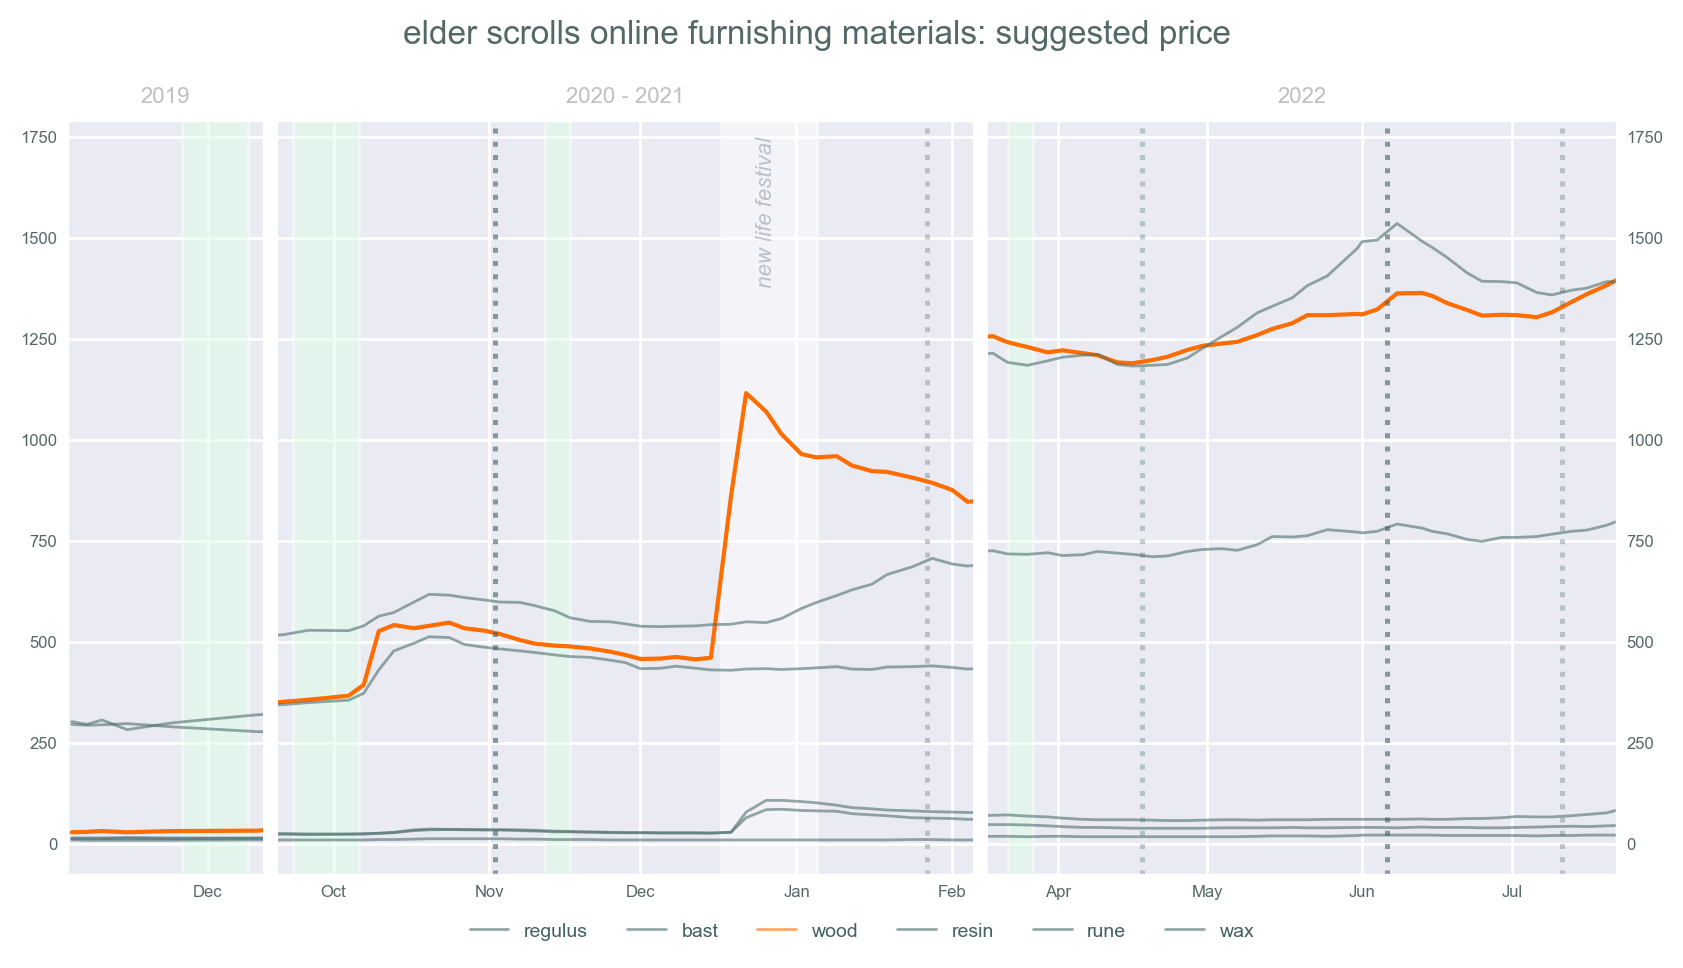

In [9]:
# create 3 subplots to hide gaps in price tracking
fig, axes = plt.subplots(
    1,
    3,
    figsize=(10, 5),
    **f,
    sharey=True,
    gridspec_kw={"width_ratios": [39, 138, 125]},
)
fig.suptitle("elder scrolls online furnishing materials: suggested price")

for ax in axes:
    ax.plot(price["wood"], lw=1.5, color=colors["wood"])
    for label in labels:
        ax.plot(price[label], lw=1, label=label, color=colors[label], alpha=0.6)

    # add lines for content release dates
    for val in test:
        ax.axvline(x=val, **pts)
    for val in release:
        ax.axvline(x=val, **update)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # xtick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # xtick label format
    ax.tick_params(**xticks)

# set x-axis limits for each plot
axes[0].set_xlim(dates["xl2019"], dates["xr2019"])
axes[1].set_xlim(dates["xl2020"], dates["xr2020"])
axes[2].set_xlim(dates["xl2022"], dates["xr2022"])

# hide inner spines
axes[0].spines["right"].set_visible(False)
axes[1].spines[["left", "right"]].set_visible(False)
axes[2].spines["left"].set_visible(False)

# show y-axis labels on right of third plot
axes[2].tick_params(labelright=True)

axes[0].set_title("2019", **titlefnt2)
axes[1].set_title("2020 - 2021", **titlefnt2)
axes[2].set_title("2022", **titlefnt2)

draw_event(date=dates["ch2019"], dur=13, subpl=axes[0], type=expl)
draw_event(date=dates["ch2020"], dur=13, subpl=axes[1], type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=axes[1], type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=axes[1], type=event)
draw_event(date=dates["expl22"], dur=5, subpl=axes[2], type=expl)

# text label for new life festival
axes[1].text(x=["2020-12-26"], y=1750, s="new life festival", **evfnt)

ax.legend(bbox_to_anchor=(-0.2, -0.11), **legend)

fig.subplots_adjust(wspace=0.03)  # squish plots closer together

#### *The Elder Scrolls Online* Furnishing Materials: Suggested Price

Since I only had a few days of 2019 prices, they're included here mostly to show how much heartwood prices (in orange) had already increased by 2020. Green highlights show in-game events that doubled the rewards from harvesting resource nodes (each node looted is equivalent to looting two separate nodes). The increased availability doesn't seem to affect prices much at any point, but heartwood spikes after the Lost Treasures of Skyrim event ends on October 5th, 2020.

Heartwood spiked a second time in late December during the New Life Festival, highlighted in white on the graph. The event asks players to craft specific furnishings using heartwood, regulus, or bast (all of which hit their maximum prices during the event) in order to receive an exclusive cosmetic item. A spike in demand for those three items is expected, but it seems unlikely that the increased demand would've caused such an extreme price increase for heartwood right at the start. 

Dotted vertical lines mark the release of major content patches adding new furnishing patterns to the game via DLC. While it's possible that the spikes before *Markarth* on November 2nd, 2020 were due to the anticipated release date, the heartwood spike is (counter-intuitively) closer to the double harvesting event's end, when supply should've been highest. Prices were already falling again before *Markarth* was released. With *High Isle* (June 6th, 2022), we don't see the same price jump weeks in advance--heartwood prices increased gradually until the release date. Mundane runes and decorative wax both hit their maximum 2022 prices on June 8th, increasing in price until a few days after *High Isle*'s release.
***************

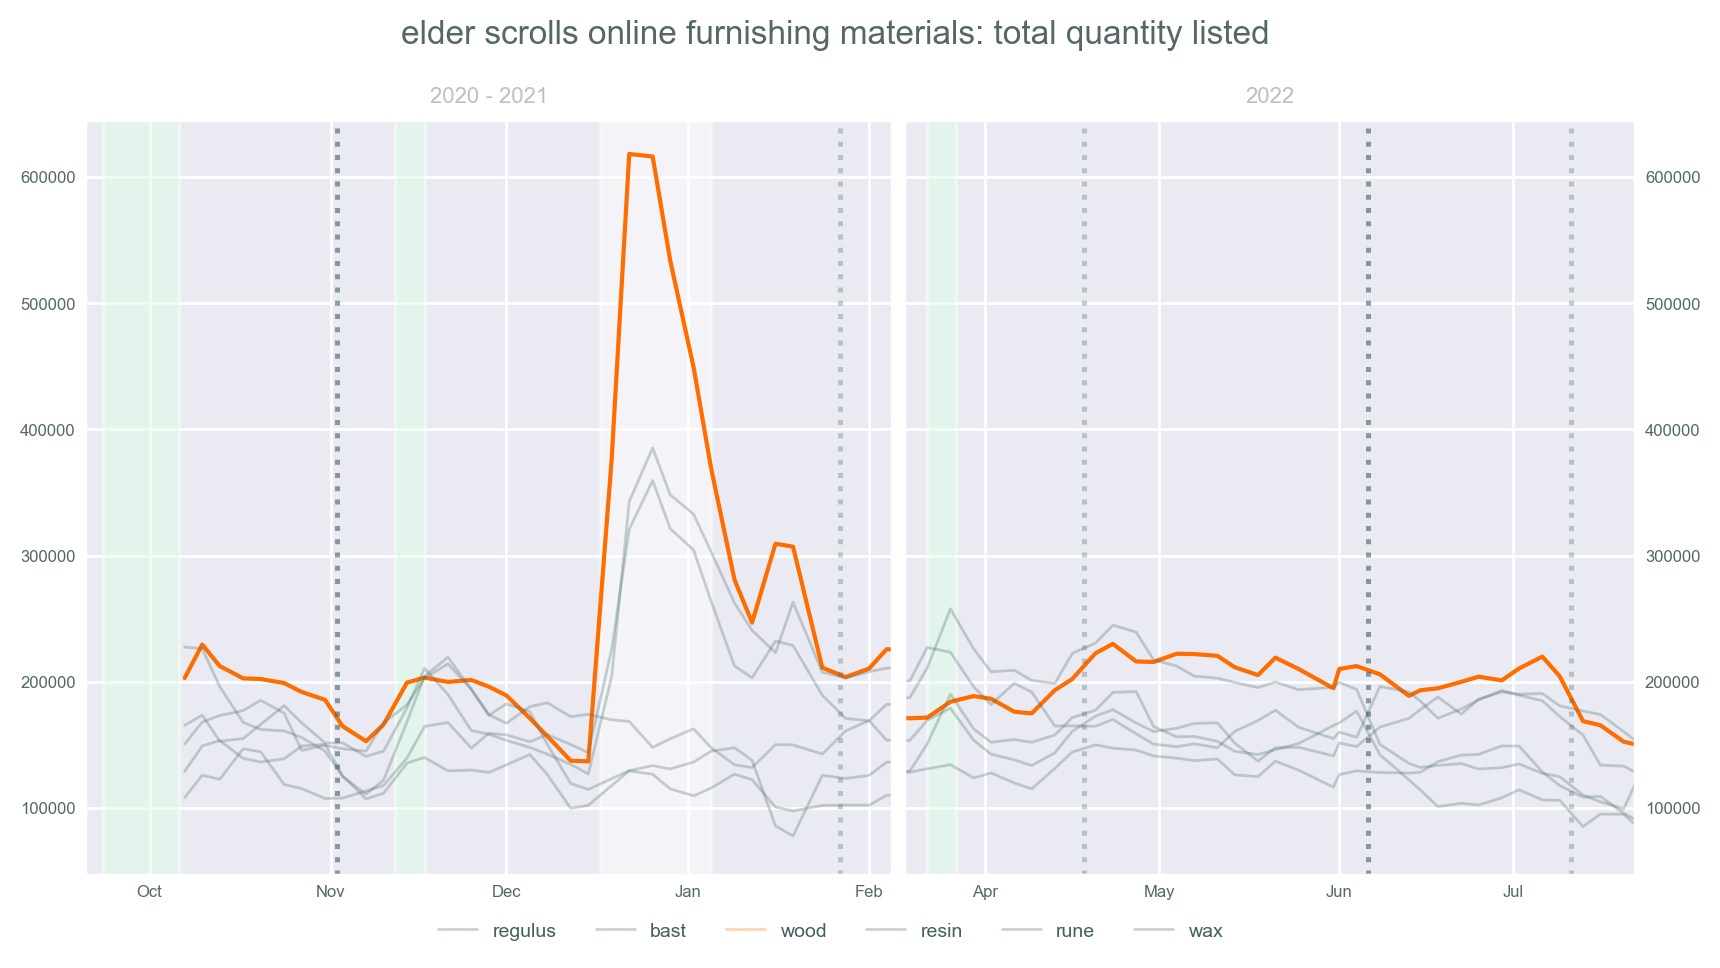

In [10]:
# create 2 subplots for quantity with gaps in time hidden, highlight wood
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), **f, sharey=True, gridspec_kw={"width_ratios": [138, 125]}
)
fig.suptitle("elder scrolls online furnishing materials: total quantity listed")

# plot quantities of main 6 mats
for ax in axes:
    ax.plot(quantity["wood"], lw=1.5, color=c["c1"])
    for label in labels:
        ax.plot(quantity[label], lw=1, label=label, color=colors[label], alpha=0.3)

    for val in test:
        ax.axvline(x=val, **pts)
    for val in release:
        ax.axvline(x=val, **update)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # xtick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # xtick label format
    ax.tick_params(**xticks)

# set x-axis time period limits for each plot
axes[0].set_xlim(dates["xl2020"], dates["xr2020"])
axes[1].set_xlim(dates["xl2022"], dates["xr2022"])

# remove overlapping axis ticks/labels
axes[0].tick_params(labelleft=True, size=0)
axes[1].tick_params(labelright=True, size=0)

axes[0].set_title("2020 - 2021", **titlefnt2)
axes[1].set_title("2022", **titlefnt2)

draw_event(date=dates["ch2020"], dur=13, subpl=axes[0], type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=axes[0], type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=axes[0], type=event)
draw_event(date=dates["expl22"], dur=5, subpl=axes[1], type=expl)

ax.legend(bbox_to_anchor=(-0.1, -0.11), **legend)

fig.subplots_adjust(wspace=0.015)  # squish plots closer together

plt.show()

#### *The Elder Scrolls Online* Furnishing Materials: Total Quantity Listed

The first two double harvesting events in 2020 appear to boost the amount listed for sale--even without data from the event in October, the gradual slope after is similar to the one after the November event. 

At the start of the New Life Festival, heartwood, regulus, and bast all have dramatic spikes in the amount listed for sale, and still aren't back to their normal levels by early February. It seems unlikely that the price was driven up by demand if the quantity available was so much higher than usual (600k vs 150-200k) and still hadn't fallen to normal levels two months later.

In 2022, there are expected spikes immediately after the March double harvesting event. The latter half of July shows quantities of all items dropping, possibly due to either the lack of double harvesting events since March, or (more likely) sellers stockpiling in anticipation of the next update. The update (*Lost Depths*) hit the public test server on July 11th, containing new items that have been requested by players for years.
**************

In [11]:
# find change in price between entries

price_diff = price.diff()  # amount of change between entries
quant_diff = quantity.diff()

price_diff = price_diff.dropna()  # remove rows with nothing to compare to
quant_diff = quant_diff.dropna()  # remove rows with nothing to compare to

price_diff = price_diff.drop(
    labels=["2020-09-21", "2022-03-19"]
)  # remove first rows after large gaps
quant_diff = quant_diff.drop(labels=["2022-03-19"])  # remove first rows after large gaps

To get a closer look at the relationship between changes in price and quantity for each item, I created dataframes for the difference between each row and the previous row.

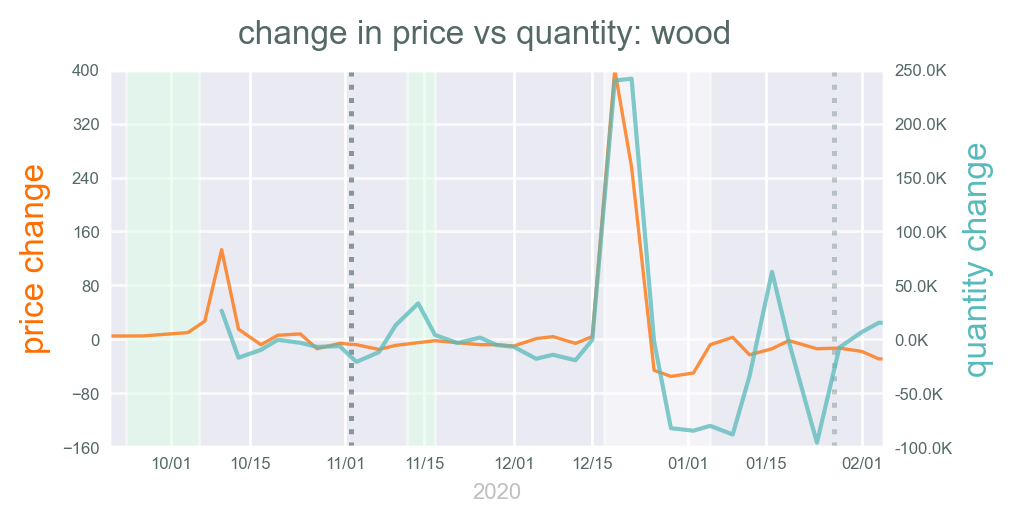

In [12]:
fig, ax1 = plt.subplots(figsize=(5, 2.5), **f)
change_plot(
    mat="wood", year="2020", lefty1=-160, lefty2=400, righty1=-100000, righty2=250000, nticks=8
)

ax1.axvline(x=["2021-01-27"], **pts)
ax1.axvline(x=["2020-11-02"], **update)

draw_event(date=dates["ch2020"], dur=13, subpl=ax1, type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=ax1, type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=ax1, type=event)

#### Change in Price vs. Quantity: Wood (2020 - 2021)
    
With changes in both price and quantity plotted, the New Life Festival heartwood spike appears to show the increased amount for sale pushing the price up--they completely overlap. The price even begins to fall before the quantity. The final days of the event (ending January 2nd, 2021) show the price falling when the amount for sale falls. The most likely explanation, in my opinion, is that players stockpile the items they know will be needed for the festival to sell at an inflated price. But after the first week of January, quantity shifts don't seem to have much of an effect on heartwood.
********************

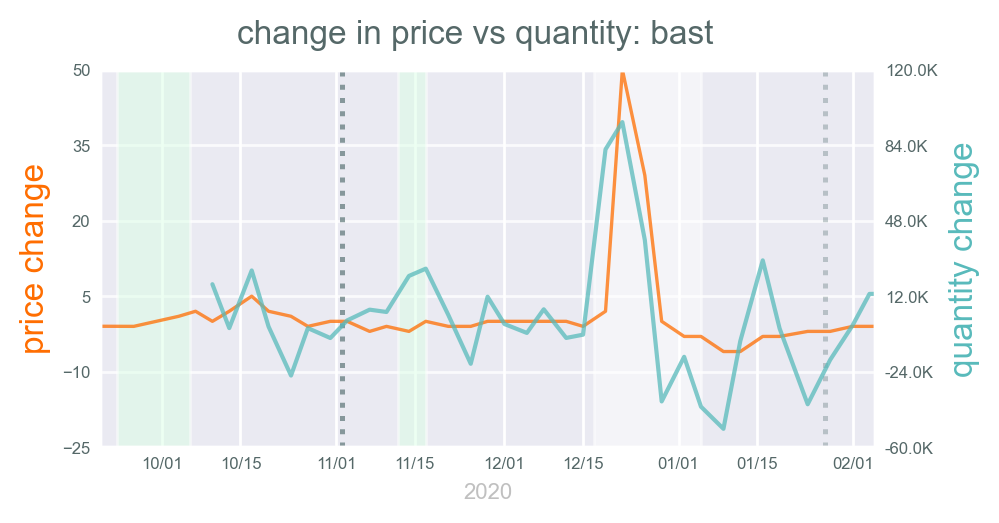

In [13]:
fig, ax1 = plt.subplots(figsize=(5, 2.5), **f)
change_plot(
    mat="bast", year="2020", lefty1=-25, lefty2=50, righty1=-60000, righty2=120000, nticks=6
)

ax1.axvline(x=["2021-01-27"], **pts)
ax1.axvline(x=["2020-11-02"], **update)

draw_event(date=dates["ch2020"], dur=13, subpl=ax1, type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=ax1, type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=ax1, type=event)

#### Change in Price vs. Quantity: Bast (2020 - 2021)
    
Like heartwood, bast's price and quantity changes both spike early during the New Life Festival, after two months of the price mostly staying flat regardless of how much more or less was listed for sale. 

***********

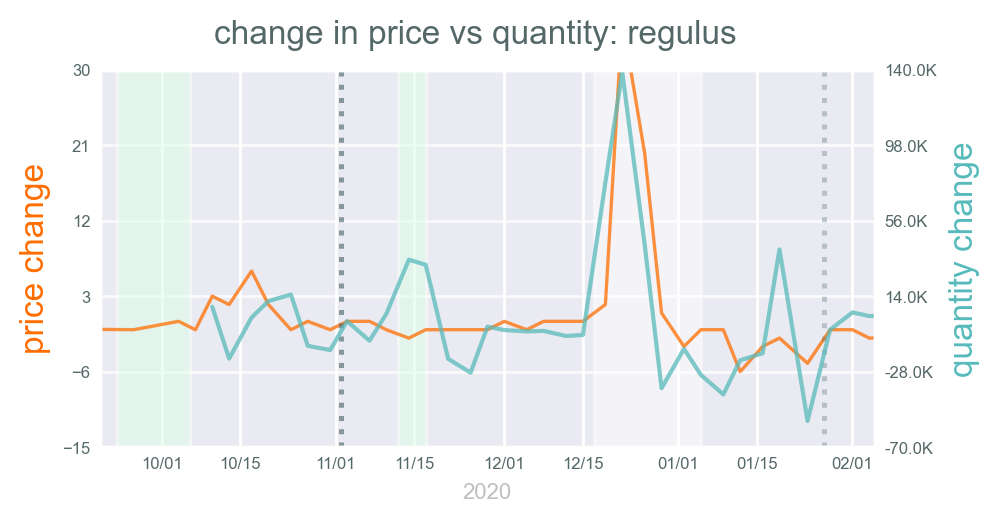

In [14]:
fig, ax1 = plt.subplots(figsize=(5, 2.5), **f)
change_plot(
    mat="regulus", year="2020", lefty1=-15, lefty2=30, righty1=-70000, righty2=140000, nticks=6
)

ax1.axvline(x=["2021-01-27"], **pts)
ax1.axvline(x=["2020-11-02"], **update)

draw_event(date=dates["ch2020"], dur=13, subpl=ax1, type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=ax1, type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=ax1, type=event)

#### Change in Price vs. Quantity: Regulus (2020 - 2021)
    
While the price change of regulus looks a bit less flat before and after the event, the New Life Festival spike looks fairly similar to bast and heartwood. The quantity spike starts right before the event (like bast), but the price and quantity changes both hit their peaks at the same time, and both stop rising at the same time.
*******************************

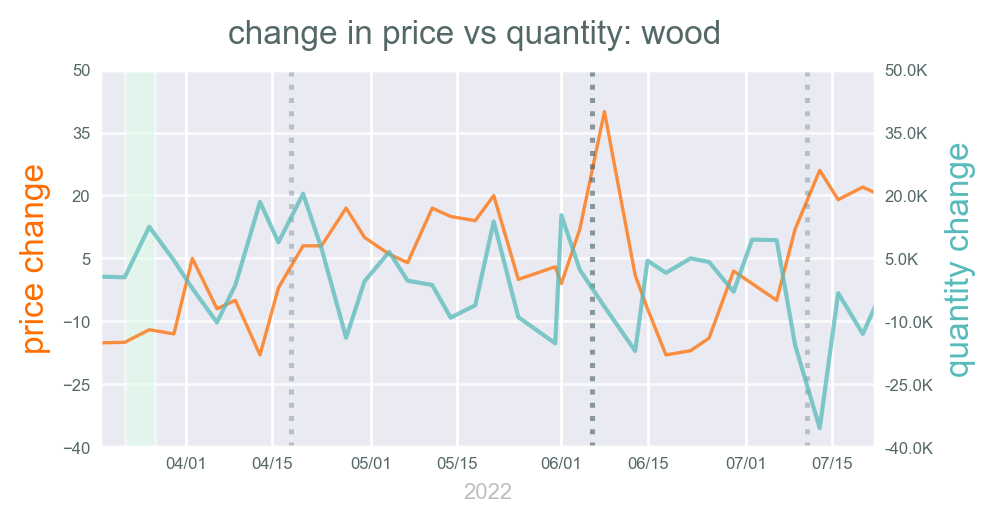

In [15]:
fig, ax1 = plt.subplots(figsize=(5, 2.5), **f)
change_plot(
    mat="wood", year="2022", lefty1=-40, lefty2=50, righty1=-40000, righty2=50000, nticks=7
)

ax1.axvline(x=["2022-04-18"], **pts)
ax1.axvline(x=["2022-07-11"], **pts)
ax1.axvline(x=["2022-06-06"], **update)
ax1.axvline(x=["2022-08-22"], **update)

draw_event(date=dates["expl22"], dur=5, subpl=ax1, type=expl)

#### Change in Price vs. Quantity: Wood (2022)
    
As a comparison for the prior three graphs, heartwood in 2020 shows a more intuitive response to changes in price and quantity. There are a few points where changes overlap: in early April, price and quantity both fell at the same time, and late May shows a price increase stopping when the amount listed for sale decreases. But for the most part, prices seem to increase most when the amount for sale decreases the most. 

***************************

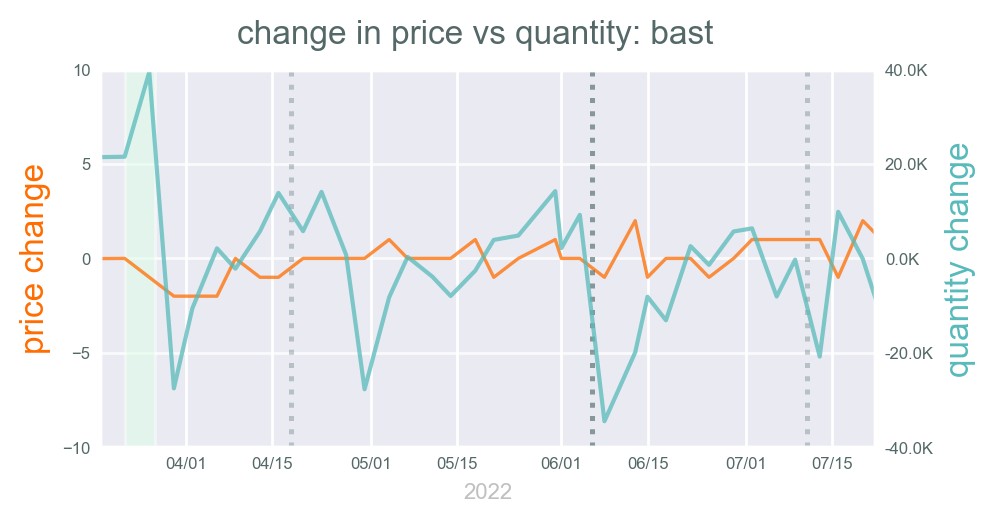

In [16]:
fig, ax1 = plt.subplots(figsize=(5, 2.5), **f)
change_plot(
    mat="bast", year="2022", lefty1=-10, lefty2=10, righty1=-40000, righty2=40000, nticks=5
)

ax1.axvline(x=["2022-04-18"], **pts)
ax1.axvline(x=["2022-07-11"], **pts)
ax1.axvline(x=["2022-06-06"], **update)
ax1.axvline(x=["2022-08-22"], **update)

draw_event(date=dates["expl22"], dur=5, subpl=ax1, type=expl)

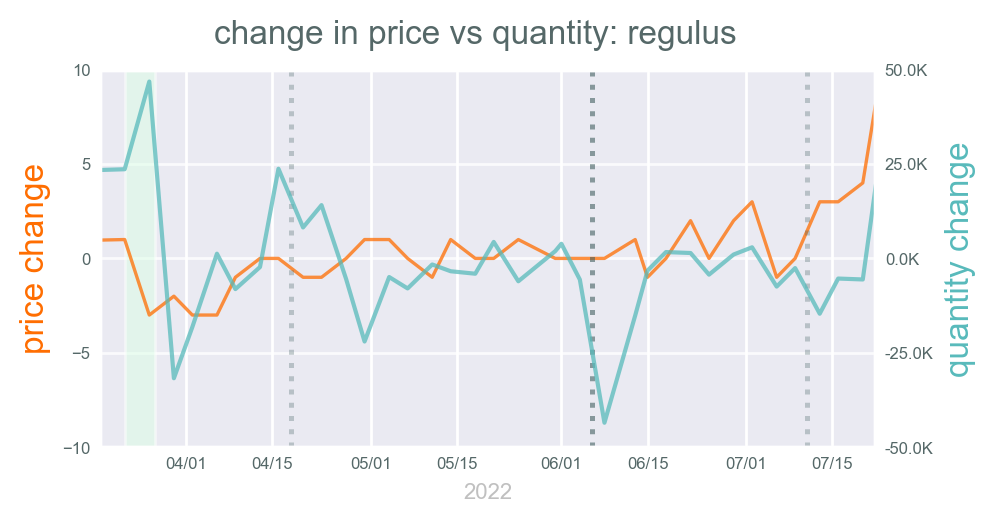

In [17]:
fig, ax1 = plt.subplots(figsize=(5, 2.5), **f)
change_plot(
    mat="regulus", year="2022", lefty1=-10, lefty2=10, righty1=-50000, righty2=50000, nticks=5
)

ax1.axvline(x=["2022-04-18"], **pts)
ax1.axvline(x=["2022-07-11"], **pts)
ax1.axvline(x=["2022-06-06"], **update)
ax1.axvline(x=["2022-08-22"], **update)

draw_event(date=dates["expl22"], dur=5, subpl=ax1, type=expl)

#### Change in Price vs. Quantity: Bast & Regulus (2022)

Bast and regulus prices remain fairly stable during quantity fluctuations.

************************************************
## Conclusion

Sellers listing at inflated prices during the New Life Festival appear to cause the largest price increases for furnishing materials. Prices increase leading up to new content releases, presumably due to either crafters stocking up in advance to craft and sell new furnishings, or sellers listing at higher prices in advance, knowing that crafters will be willing to pay more to use any new patterns they learn. 

Double harvesting events don't appear to lead to a decrease in prices, despite increasing the amount listed for sale. The unlimited craft bag given to players as a perk of having an active ESO Plus subscription may play a part by removing any pressure to clear inventory space by selling crafting materials.


************************************************

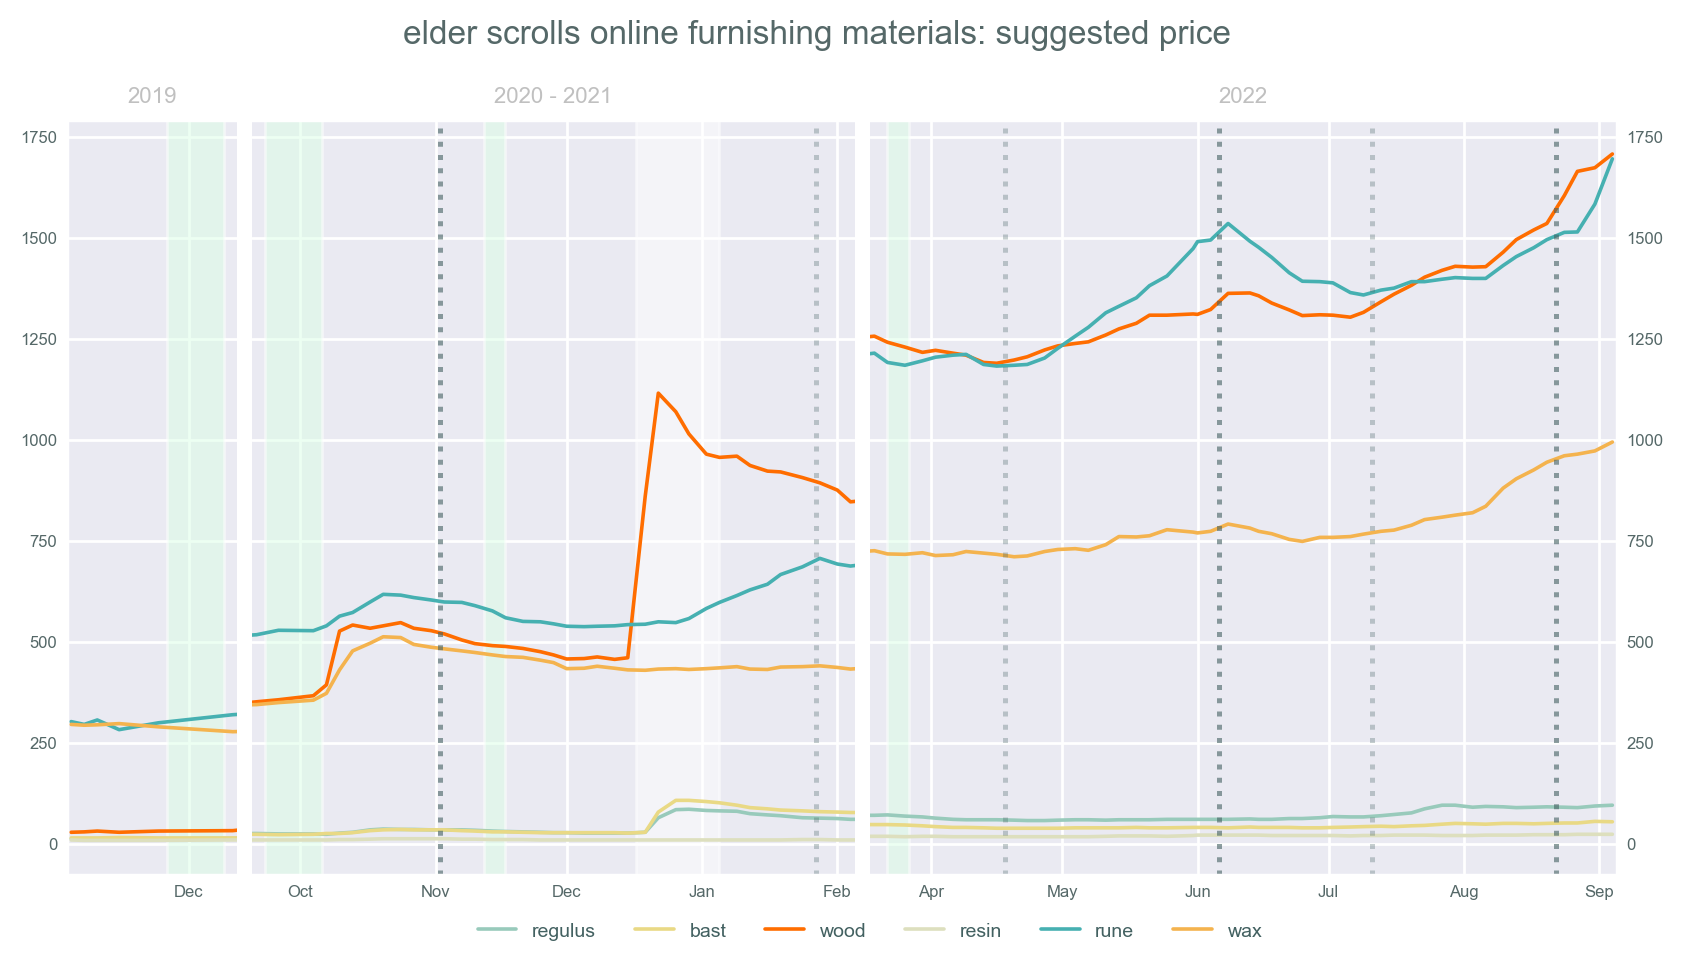

In [18]:
colors.update(
    {
        "regulus": "#98CABB",
        "bast": "#E9D985",
        "resin": "#DDDFBE",
        "rune": "#46B0B1",
        "wax": "#F4B34E",
    }
)

# create 3 subplots to hide gaps in price tracking
fig, axes = plt.subplots(
    1,
    3,
    figsize=(10, 5),
    **f,
    sharey=True,
    gridspec_kw={"width_ratios": [39, 138, currentplot]},
)
fig.suptitle("elder scrolls online furnishing materials: suggested price")

for ax in axes:
    for label in labels:
        ax.plot(price[label], lw=1.3, label=label, color=colors[label])

    # add lines for content release dates
    for val in test:
        ax.axvline(x=val, **pts)
    for val in release:
        ax.axvline(x=val, **update)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # xtick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # xtick label format
    ax.tick_params(**xticks)

# set x-axis limits for each plot
axes[0].set_xlim(dates["xl2019"], dates["xr2019"])
axes[1].set_xlim(dates["xl2020"], dates["xr2020"])
axes[2].set_xlim(dates["xl2022"], current)

# hide inner spines
axes[0].spines["right"].set_visible(False)
axes[1].spines[["left", "right"]].set_visible(False)
axes[2].spines["left"].set_visible(False)

# show y-axis labels on right of third plot
axes[2].tick_params(labelright=True)

axes[0].set_title("2019", **titlefnt2)
axes[1].set_title("2020 - 2021", **titlefnt2)
axes[2].set_title("2022", **titlefnt2)

draw_event(date=dates["ch2019"], dur=13, subpl=axes[0], type=expl)
draw_event(date=dates["ch2020"], dur=13, subpl=axes[1], type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=axes[1], type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=axes[1], type=event)
draw_event(date=dates["expl22"], dur=5, subpl=axes[2], type=expl)

ax.legend(bbox_to_anchor=(0, -0.11), **legend)

fig.subplots_adjust(wspace=0.03)  # squish plots closer together

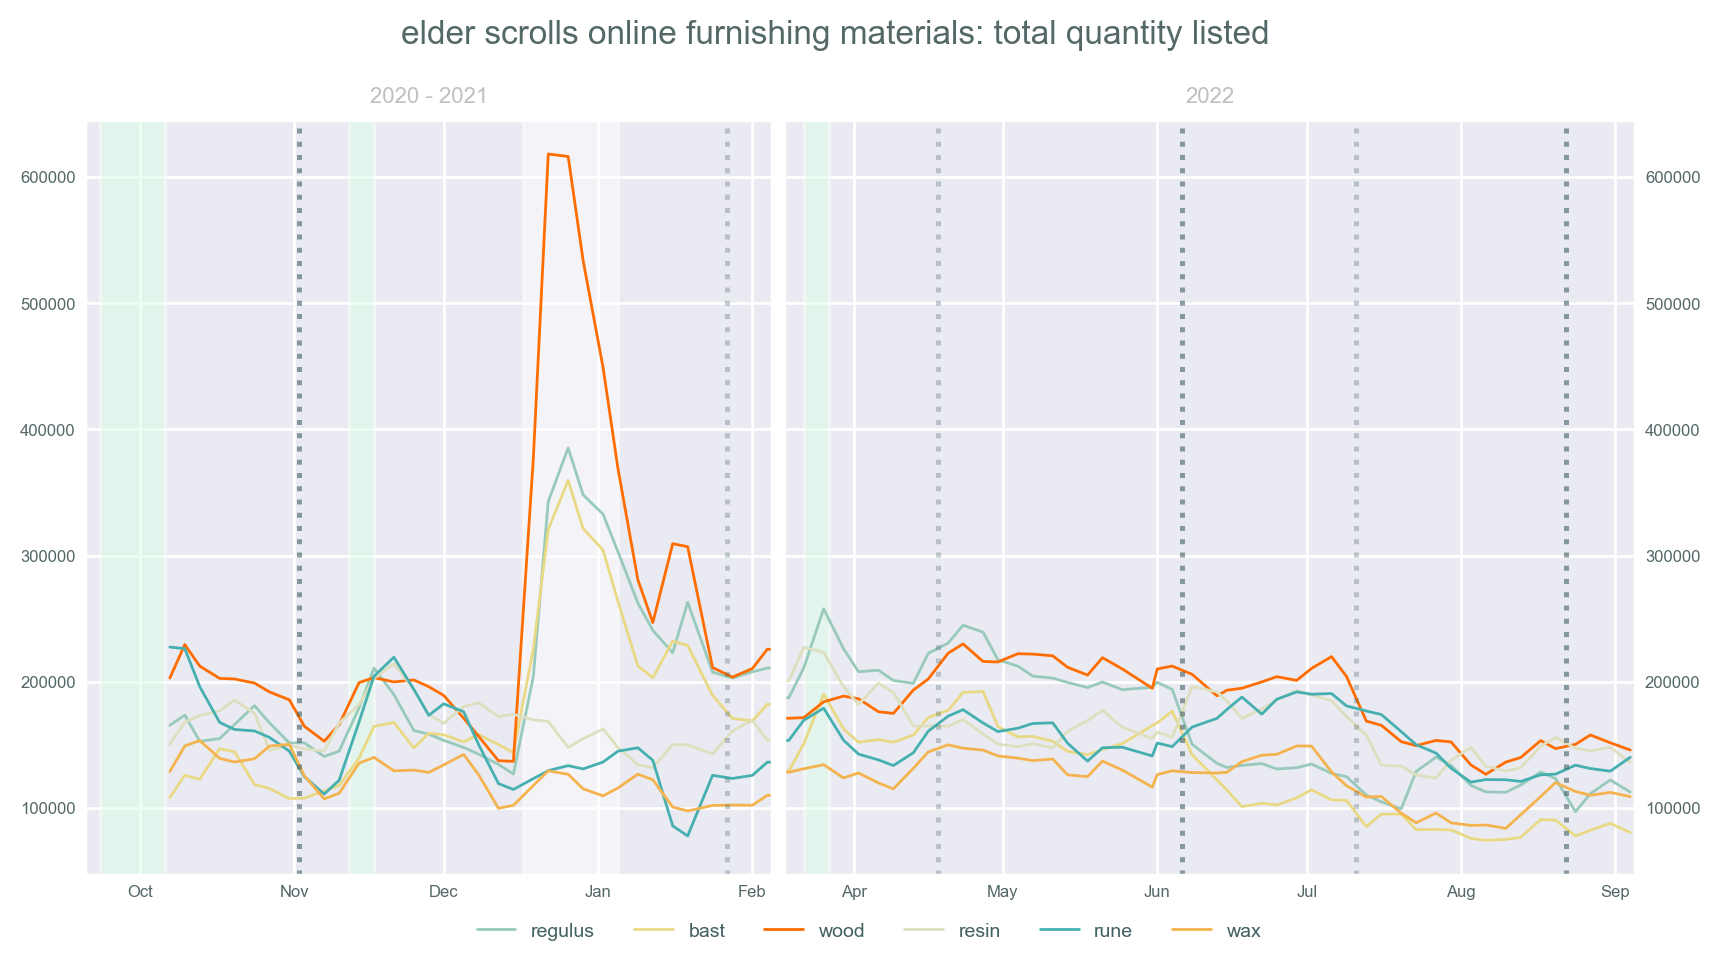

In [19]:
# create 2 subplots for quantity with gaps in time hidden, highlight wood
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    **f,
    sharey=True,
    gridspec_kw={"width_ratios": [138, currentplot]},
)
fig.suptitle("elder scrolls online furnishing materials: total quantity listed")

# plot quantities of main 6 mats
for ax in axes:
    for label in labels:
        ax.plot(quantity[label], lw=1, label=label, color=colors[label])

    for val in test:
        ax.axvline(x=val, **pts)
    for val in release:
        ax.axvline(x=val, **update)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # xtick locations
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # xtick label format
    ax.tick_params(**xticks)

# set x-axis time period limits for each plot
axes[0].set_xlim(dates["xl2020"], dates["xr2020"])
axes[1].set_xlim(dates["xl2022"], current)

# remove overlapping axis ticks/labels
axes[0].tick_params(labelleft=True, size=0)
axes[1].tick_params(labelright=True, size=0)

axes[0].set_title("2020 - 2021", **titlefnt2)
axes[1].set_title("2022", **titlefnt2)

draw_event(date=dates["ch2020"], dur=13, subpl=axes[0], type=expl)
draw_event(date=dates["expl20"], dur=5, subpl=axes[0], type=expl)
draw_event(date=dates["nwlf20"], dur=19, subpl=axes[0], type=event)
draw_event(date=dates["expl22"], dur=5, subpl=axes[1], type=expl)

plt.legend(bbox_to_anchor=(0.1, -0.11), **legend)

fig.subplots_adjust(wspace=0.015)  # squish plots closer together

plt.show()